# Execution Times

We evaluate the time performance of our algorithm on the datasets of the real world example we introduced in 4.3.

We are not able to publish the complete dataset that we used for the calculation of the execution times.
But we provide a single timestep for each of the size classes. Four timesteps of the real data simulation for each class were used in our paper.


In [4]:
# IMPORT

import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from VoCC import VortexCorrelationClustering
from time import time

In [15]:
data_file_lookup = {
    '20K': ['../data/particles_11012016.npy'],
    '70K': ['../data/particles_04052015.npy'],
    '120K': ['../data/particles_09122013.npy'],
    '280K': ['../data/particles_02112013.npy']
}


def measure_time(iters, amounts, config_result):

    # Setup
    for amount in amounts:
        times = []
        timesteps_times = {}
        for timestep_i, timestep_file in enumerate(data_file_lookup[amount]):
            execution_times = []
            coordinates = np.load(timestep_file)
            if 'dbscan' in config_result:
                minimum_samples = 50
                
                X = coordinates[:, :2]
                for _ in range(iters):
                    start = time()
                    db = DBSCAN(eps=config_result['eps'], min_samples=config_result['min_pts'], metric='haversine', algorithm='ball_tree').fit(np.radians(X))
                    execution_time = time() - start
                    execution_times.append(execution_time)

            else:

                for _ in range(iters):

                    start = time()
                    vocc = VortexCorrelationClustering(radii = config_result['radii'], resolution=.05, sectors = config_result['sectors'],circle_coverage_rate= config_result['circle_coverage_rate'],qth_threshold = .99, min_points=.01)
                    _ = vocc.fit(coordinates)
                    execution_time = time() - start
                    execution_times.append(execution_time)

            timesteps_times[timestep_i] = (np.mean(execution_times), execution_times)
            times.append(np.mean(execution_times))

        timesteps_times['mean_time'] = np.mean(times)
        config_result[amount] = timesteps_times

    return config_result

In [16]:
# Measuring the time off different VoCC configurations and DBSCAN on 4 different size classes of data.

# VorCC
iters = 8
amounts = ['20K', '70K', '120K', '280K']
VoCC1 = measure_time(iters, amounts, {'resolution' : 0.05, 'mode' : 'direction', 'radii' : np.arange(6,24,3), 'sectors' : 1, 'circle_coverage_rate' : .75})

VoCC2 = measure_time(iters, amounts, {'resolution' : 0.05, 'mode' : 'direction', 'radii' : np.arange(6,24,3), 'sectors' : 7, 'circle_coverage_rate' : .75})

VoCC3 = measure_time(iters, amounts, {'resolution' : 0.05, 'mode' : 'direction', 'radii' : np.arange(6,15,3), 'sectors' : 7, 'circle_coverage_rate' : .75})

VoCC4 = measure_time(iters, amounts, {'resolution' : 0.05, 'mode' : 'direction', 'radii' : np.arange(6,24,6), 'sectors' : 7, 'circle_coverage_rate' : .75})


# #DBSCAN
dbscan = measure_time(iters, amounts, {'dbscan' : True, 'kms_per_radian' : 6371, 'eps' : 10 / 6371, 'min_pts': 50})

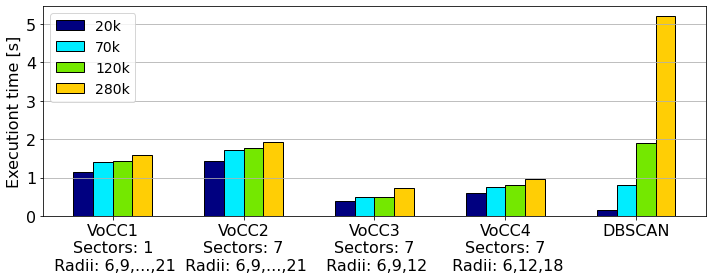

In [18]:
# Plotting the results of the time measurements
labels = ['VoCC1\nSectors: 1\n Radii: 6,9,...,21', 
'VoCC2\nSectors: 7\n Radii: 6,9,...,21', 
'VoCC3\nSectors: 7\n Radii: 6,9,12', 
'VoCC4\nSectors: 7\n Radii: 6,12,18', 
'DBSCAN']

mean_20k = [VoCC1['20K']['mean_time'], VoCC2['20K']['mean_time'], VoCC3['20K']['mean_time'], VoCC4['20K']['mean_time'], dbscan['20K']['mean_time']]
mean_70k = [VoCC1['70K']['mean_time'], VoCC2['70K']['mean_time'], VoCC3['70K']['mean_time'], VoCC4['70K']['mean_time'], dbscan['70K']['mean_time']]
mean_120k = [VoCC1['120K']['mean_time'], VoCC2['120K']['mean_time'], VoCC3['120K']['mean_time'], VoCC4['120K']['mean_time'], dbscan['120K']['mean_time']]
mean_200k = [VoCC1['280K']['mean_time'], VoCC2['280K']['mean_time'], VoCC3['280K']['mean_time'], VoCC4['280K']['mean_time'], dbscan['280K']['mean_time']]


x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars
colors = plt.cm.gist_ncar(np.linspace(0, 1, 6))
fig, ax = plt.subplots(figsize = (10,4))
rects1 = ax.bar(x - 3*width/2, mean_20k, width, label='20k', color = colors[0], edgecolor = 'k')
rects2 = ax.bar(x - width/2, mean_70k, width, label='70k', color = colors[1], edgecolor = 'k')
rects3 = ax.bar(x + width/2, mean_120k, width, label='120k', color = colors[2], edgecolor = 'k')
rects4 = ax.bar(x + 3*width/2, mean_200k, width, label='280k', color = colors[3], edgecolor = 'k')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Executiont time [s]', fontsize = 16)
ax.set_xticks(x, labels, fontsize = 16)
ax.set_yticks(np.arange(6), np.arange(6), fontsize = 16)
ax.legend(fontsize = 14)
ax.grid(axis='y')
# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.savefig('../fig/execution_times.png', dpi = 200)